In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pickle
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score # recall scorer
from sklearn.metrics import precision_score # precision scorer
from sklearn.metrics import roc_curve # ROC curve
from sklearn.metrics import f1_score # f1

from sklearn import *
from sklearn.svm import SVC, LinearSVC
import itertools

import os
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec 
from gensim.models import KeyedVectors
from scipy import spatial

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD, NMF

import umap
import umap.plot

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
import joblib
from joblib import Memory

In [2]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove/glove.6B.300d.txt", 'r') as f:

    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [3]:
print(np.linalg.norm(embeddings_dict['queen']-embeddings_dict['king']-embeddings_dict['wife']+embeddings_dict['husband']))
print(np.linalg.norm(embeddings_dict['queen']-embeddings_dict['king']))
print(np.linalg.norm(embeddings_dict['wife']-embeddings_dict['husband']))

6.165036
5.966258
3.1520464


In [4]:
root_folder='.'
glove_folder_name='glove'
glove_filename='glove.6B.300d.txt'
glove_path = os.path.abspath(os.path.join(root_folder, glove_folder_name, glove_filename))
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

<ipython-input-4-c08446cc6b8f>:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


In [5]:
result = model.similar_by_word("king")
print("king is similar to {}: {:.4f}".format(*result[0]))
result = model.similar_by_word("wife")
print("wife is similar to {}: {:.4f}".format(*result[0]))

king is similar to queen: 0.6336
wife is similar to husband: 0.8646


In [6]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

print(find_closest_embeddings(embeddings_dict["queen"] - embeddings_dict["king"] + embeddings_dict["husband"])[:5])

['husband', 'wife', 'mother', 'daughter', 'grandmother']


In [7]:
df = pd.read_csv("dataset.csv")
print('Number of data points : ', df.shape[0])
print('Number of features : ', df.shape[1])
df.head()

Number of data points :  2072
Number of features :  9


,Unnamed: 0,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,590,Having made a massive impact in Saudi Arabia w...,Having made a massive impact in Saudi Arabia w...,"['singhs', 'rooting', 'cool', 'saudi', 'style'...",NaN,[],https://www.msn.com/en-in/entertainment/other/...,cricket,sports
1,388,Cricket is all about the emotional rollercoast...,"No matter which team fans hope to win, every s...","['wants', 'fans', 'finals', 'cup', 'win', 'tou...",NaN,[],https://www.prnewswire.com:443/news-releases/c...,cricket,sports
2,423,New Zealand announces back-to-back tours next ...,New Zealand announces back-to-back tours next ...,"['test', 'west', 'tour', 'zealand', 'world', '...",2021-12-20 00:00:00,[],https://www.aljazeera.com/news/2021/12/20/cric...,cricket,sports
3,563,It's not the first time cricket fans in the co...,Billed as one of the pre-tournament favourites...,"['qualify', 'afghanistan', 'cup', 'world', 'ze...",NaN,[],https://www.msn.com/en-in/news/other/t20-world...,cricket,sports
4,634,An employee works on a computer terminal again...,"REUTERS/Sivaram VBENGALURU, Oct 11 (Reuters Br...","['success', 'tech', 'startup', 'talent', 'onli...",2021-10-11 00:00:00,['Una Galani'],https://www.reuters.com/breakingviews/india-in...,cricket,sports


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

In [9]:
print('Number of data points in train data:', train.shape[0])
print('Number of data points in test data:', test.shape[0])

Number of data points in train data: 1657
Number of data points in test data: 415


### Cleaning

In [10]:
import re
def clean(text):
    text = re.sub(r"http\S+", '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    texter = re.sub(r"[0-9]","", texter)
    texter = re.sub('[^a-zA-Z0-9\n]', ' ', texter)
    texter = re.sub('\s+',' ', texter)
    texter = texter.lower()
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [11]:
X_train = train['full_text'].apply(clean)

In [12]:
X_test = test['full_text'].apply(clean)

In [13]:
X_train.head()

1073    tell us are you a wildfire victim having a pro...
1656    here s why the f tremor is only available with...
261     texas finally halted its losing streak at six ...
450     cedar city utah ap beau kelly set up the game ...
522     the old military maxim of hurry up and wait ma...
Name: full_text, dtype: object

In [14]:
X_test.head()

481     the sun belt conference championship game will...
1267    governor greg abbott today directed the texas ...
1748    many of us remember the magnitude central virg...
837     comedian dave chappelle said monday he d be wi...
1956    credit pixabay cc public domain drought can ca...
Name: full_text, dtype: object

In [15]:
y_train_encoded = train["root_label"].copy()
y_test_encoded = test["root_label"].copy()

y_train_encoded[y_train_encoded == 'sports'] = 0
y_test_encoded[y_test_encoded == 'sports'] = 0


y_train_encoded[y_train_encoded== 'climate'] = 1
y_test_encoded[y_test_encoded == 'climate'] = 1

print("Training Set\n")
print("Original train_dataset:\n" + str(train["root_label"][0:20]))
print("\nBinarized train_dataset:\n" + str(y_train_encoded[0:20]))
print("\nTest Set\n")
print("Original test_dataset:\n" + str(test["root_label"][0:20]))
print("\nBinarized test_dataset:\n" + str(y_test_encoded[0:20]))

Training Set

Original train_dataset:
1073    climate
1656    climate
261      sports
450      sports
522      sports
1711    climate
1630    climate
282      sports
1002     sports
1297    climate
1917    climate
985      sports
2062    climate
1252    climate
1651    climate
338      sports
1358    climate
1381    climate
306      sports
453      sports
Name: root_label, dtype: object

Binarized train_dataset:
1073    1
1656    1
261     0
450     0
522     0
1711    1
1630    1
282     0
1002    0
1297    1
1917    1
985     0
2062    1
1252    1
1651    1
338     0
1358    1
1381    1
306     0
453     0
Name: root_label, dtype: object

Test Set

Original test_dataset:
481      sports
1267    climate
1748    climate
837      sports
1956    climate
825      sports
508      sports
399      sports
1566    climate
134      sports
1972    climate
2057    climate
674      sports
1399    climate
290      sports
291      sports
855      sports
746      sports
743      sports
2071    climat

In [16]:
class Word2VecVectorizer:
    def __init__(self, model):
        print("Loading in word vectors...")
        self.word_vectors = model
        print("Finished loading in word vectors")
    
    def fit(self, data):
        pass
    
    def transform(self, data):
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0
            for word in tokens:
                try:
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [17]:
vectorizer = Word2VecVectorizer(model)

Loading in word vectors...
Finished loading in word vectors


In [18]:
X_train_fit = vectorizer.fit_transform(X_train)
y_train = y_train_encoded.astype(str).astype(int)
X_test_fit = vectorizer.transform(X_test)
y_test = y_test_encoded.astype(str).astype(int)
print(X_train_fit.shape,X_test_fit.shape)

Number of samples with no words found: 0 / 1657
Number of samples with no words found: 0 / 415
(1657, 300) (415, 300)


In [19]:
clf_cv_Glove = svm.SVC(random_state=42)
param_grid = {'C': [0.001,0.01,0.1,1,10,100,200,400,600,800,1000],  
              'kernel': ['linear']}
Glove_model = GridSearchCV(clf_cv_Glove,param_grid,cv=5,scoring='accuracy',n_jobs=-1).fit(X_train_fit, y_train)
y_pred_glove = Glove_model.best_estimator_.predict(X_test_fit)

In [20]:
print(Glove_model.best_estimator_)

SVC(C=10, kernel='linear', random_state=42)


In [21]:
print("Accuracy (Best GLoVE classifier):", accuracy_score(y_test,y_pred_glove))
print("Recall (Best GLoVE classifier):", recall_score(y_test,y_pred_glove))
print("Precision (Best GLoVE classifier):", precision_score(y_test,y_pred_glove))
print("F1-Score (Best GLoVE classifier):", f1_score(y_test,y_pred_glove))

Accuracy (Best GLoVE classifier): 0.9614457831325302
Recall (Best GLoVE classifier): 0.9669811320754716
Precision (Best GLoVE classifier): 0.9579439252336449
F1-Score (Best GLoVE classifier): 0.9624413145539905


In [22]:
filenames_glove = ['glove.6B.50d.txt','glove.6B.100d.txt','glove.6B.200d.txt','glove.6B.300d.txt']
accu_list_glove = []
for filename in filenames_glove:
    print('Training for: ', filename)
    glove_filename=filename
    glove_path = os.path.abspath(os.path.join(root_folder, glove_folder_name, glove_filename))
    word2vec_output_file = glove_filename+'.word2vec'
    glove2word2vec(glove_path, word2vec_output_file)
    model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    vectorizer = Word2VecVectorizer(model)
    X_train_fit = vectorizer.fit_transform(X_train)
    y_train = y_train_encoded.astype(str).astype(int)
    X_test_fit = vectorizer.transform(X_test)
    y_test = y_test_encoded.astype(str).astype(int)
    clf_cur = svm.SVC(kernel='linear',C=1,random_state=42)
    pred_cur = clf_cur.fit(X_train_fit, y_train).predict(X_test_fit)
    accu_list_glove.append(accuracy_score(y_test,pred_cur))  

Training for:  glove.6B.50d.txt


<ipython-input-22-ac52878dca75>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 1657
Number of samples with no words found: 0 / 415
Training for:  glove.6B.100d.txt


<ipython-input-22-ac52878dca75>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 1657
Number of samples with no words found: 0 / 415
Training for:  glove.6B.200d.txt


<ipython-input-22-ac52878dca75>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 1657
Number of samples with no words found: 0 / 415
Training for:  glove.6B.300d.txt


<ipython-input-22-ac52878dca75>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 1657
Number of samples with no words found: 0 / 415


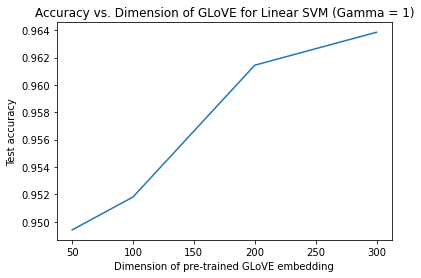

In [24]:
dim_list = [50,100,200,300]
plt.plot(dim_list,accu_list_glove)
plt.title('Accuracy vs. Dimension of GLoVE for Linear SVM (Gamma = 1)')
plt.xlabel('Dimension of pre-trained GLoVE embedding')
plt.ylabel('Test accuracy')
plt.show()

In [25]:
reduced_dim_embedding = umap.UMAP(n_components=2, metric='euclidean').fit(X_train_fit)
print(reduced_dim_embedding.embedding_.shape)

(1657, 2)


In [26]:
YtrainTextLabel = []
for label in y_train:
    if(label==0):
        YtrainTextLabel.append('Sports')
    else:
        YtrainTextLabel.append('Climate')

s = np.random.normal(0, 1, [4732,300])
s = s / np.linalg.norm(s)
reduced_dim_s = umap.UMAP(n_components=2, metric='cosine').fit(s)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


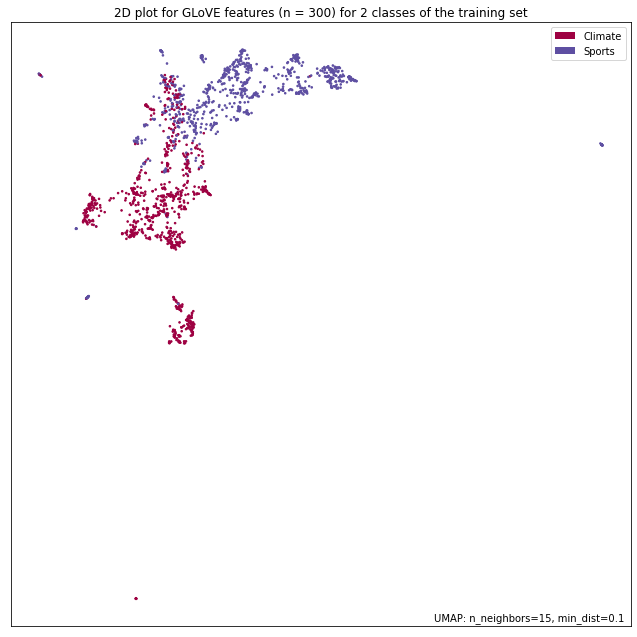

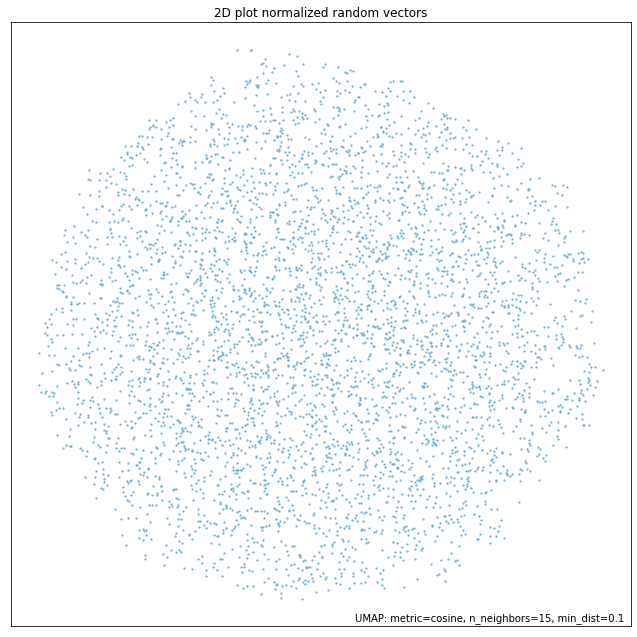

In [27]:
f = umap.plot.points(c, labels=np.array(YtrainTextLabel))
plt.title('2D plot for GLoVE features (n = 300) for 2 classes of the training set')

g = umap.plot.points(reduced_dim_s)
plt.title('2D plot normalized random vectors')
plt.show()